In [46]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

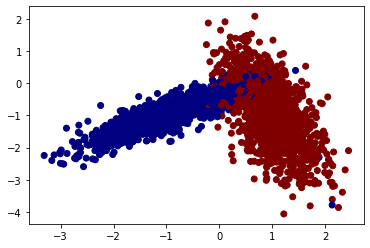

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'orange', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test, cmap="jet_r")
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [48]:
# it will take classifier and set of values for hyper prameter in dict type dict({hyper parmeter: [list of values]})
# we are implementing this only for KNN, the hyper parameter should n_neighbors
from sklearn.metrics import accuracy_score

# Reference: https://www.kaggle.com/bhushanyadav07/implementing-custom-randomsearchcv

#def randomly_select_60_percent_indices_in_range_from_1_to_len(x_train):
#    return random.sample(range(0, len(x_train)), int(0.6*len(x_train)))

import random

#generate 10 unique values(uniform random distribution)
def randomParameterGen(param_range):
    parVal = random.sample(range(1,param_range),10)
    parVal.sort()
    return parVal

#devide numbers ranging from  0 to len(X_train) into groups= folds
def train_cv_indices(train_data,i,folds):
    l = int(len(train_data)/folds)
    return list(set(list(range((l * i), (l * (i + 1)))))) #group 1: 0-33, group 2:34-66, group 3: 67-100

def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    trainscores = []
    testscores  = []    
    
    param_list = randomParameterGen(param_range)
    params = {'n_neighbors' : param_list}
    
    print(params)
    
    for k in tqdm(params['n_neighbors']):
        trainscores_folds = []
        testscores_folds  = []
        
        for j in range(0, folds):
            # check this out: https://stackoverflow.com/a/9755548/4084039
            #train_indices = randomly_select_60_percent_indices_in_range_from_1_to_len(x_train)
            
            test_indices = train_cv_indices(x_train,j,folds)
            train_indices  = list(set(list(range(1, len(x_train)))) - set(test_indices))

            # selecting the data points based on the train_indices and test_indices
            X_train = x_train[train_indices]
            Y_train = y_train[train_indices]
            X_test  = x_train[test_indices]
            Y_test  = y_train[test_indices]

            classifier.n_neighbors = k
            classifier.fit(X_train,Y_train)

            Y_predicted = classifier.predict(X_test)
            testscores_folds.append(accuracy_score(Y_test, Y_predicted))

            Y_predicted = classifier.predict(X_train)
            trainscores_folds.append(accuracy_score(Y_train, Y_predicted))
        trainscores.append(np.mean(np.array(trainscores_folds)))
        testscores.append(np.mean(np.array(testscores_folds)))
    return trainscores,testscores, params

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

{'n_neighbors': [1, 10, 12, 14, 16, 22, 30, 33, 34, 38]}


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.44s/it]


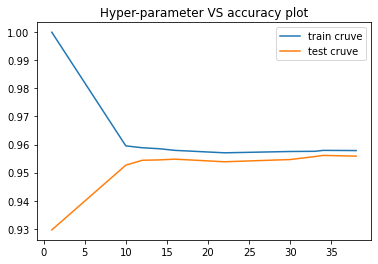

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")


neigh = KNeighborsClassifier()

#params = {'n_neighbors':[3,5,7,9,11,13,15,17,19,21,23]}

param_range = 50
folds = 3

trainscores,testscores,params = RandomSearchCV(X_train, y_train, neigh, param_range, folds)
 

plt.plot(params['n_neighbors'],trainscores, label='train cruve')
plt.plot(params['n_neighbors'],testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

##### plot the decision boundaries

In [50]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

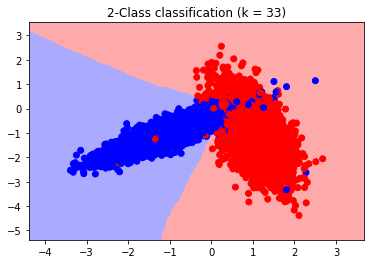

In [51]:
# Most Accurate K value got from Hyper-parameter VS accuracy plot [33,34]
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 33)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

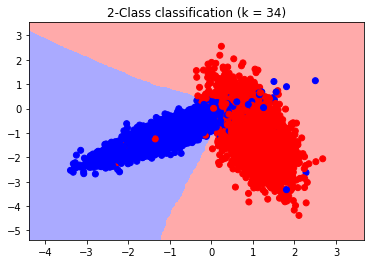

In [52]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 34)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

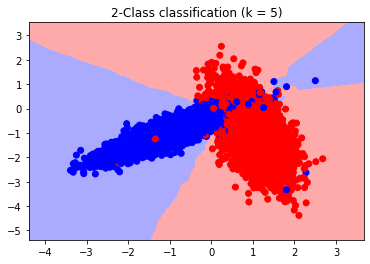

In [53]:
# decision boundarie when K =5
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 5)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

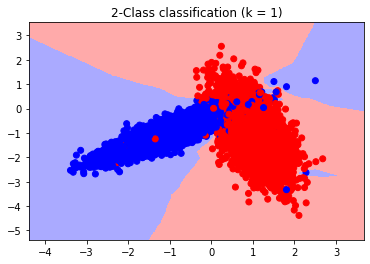

In [54]:
# decision boundarie when K = 1
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 1)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)